### Тема: Изучение влияния различных исторических событий на количество снимаемых фильмов различных жанров

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('fast')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 9,6

In [3]:
title_basic = pd.read_csv('title.basics.tsv', sep='\t')

In [4]:
title_basic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5844669 entries, 0 to 5844668
Data columns (total 9 columns):
tconst            object
titleType         object
primaryTitle      object
originalTitle     object
isAdult           int64
startYear         object
endYear           object
runtimeMinutes    object
genres            object
dtypes: int64(1), object(8)
memory usage: 401.3+ MB


In [5]:
#Отсеиваем фильны без даты и жанра
title_basic = title_basic.drop(title_basic.loc[title_basic['startYear'] == '\\N'].index, axis=0)
title_basic = title_basic.drop(title_basic.loc[title_basic['genres'] == '\\N'].index, axis=0)

#Оставляем только фильмы
title_basic = title_basic.drop(title_basic.loc[title_basic['titleType'] != 'movie'].index, axis=0)

#Отсеиваем фильмы без хронометража и переводим его в int
title_basic = title_basic.drop(title_basic.loc[title_basic['runtimeMinutes'] == '\\N'].index, axis=0)
title_basic['runtimeMinutes'] = title_basic['runtimeMinutes'].astype(int)
#title_basic = title_basic.drop(title_basic.loc[title_basic['runtimeMinutes'] < 40].index, axis=0)

#Удаляем фильмы которые еще не вышли
title_basic['startYear'] = title_basic['startYear'].astype(int)
title_basic = title_basic.drop(title_basic.loc[title_basic['startYear'] > 2019].index, axis=0)

In [6]:
title_basic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295104 entries, 8 to 5844566
Data columns (total 9 columns):
tconst            295104 non-null object
titleType         295104 non-null object
primaryTitle      295104 non-null object
originalTitle     295104 non-null object
isAdult           295104 non-null int64
startYear         295104 non-null int32
endYear           295104 non-null object
runtimeMinutes    295104 non-null int32
genres            295104 non-null object
dtypes: int32(2), int64(1), object(6)
memory usage: 20.3+ MB


In [7]:
# Функция возвращающая датафрейм с количеством фильмов каждого жанра в заданном году
def year(datafarme, year):
    
    data = datafarme.loc[datafarme['startYear'] == year].reset_index()
    
    dict_ = {'year':year}

    for film in data['genres']:
        for genre in film.split(sep=','):
            if genre in dict_:
                dict_[genre] += 1
            else:
                dict_[genre] = 0
    
    dict_['number'] = data.shape[0]
    
    return pd.DataFrame(dict_, index=[year])

In [8]:
#Рассматриваемый временой промежуток
min_year = title_basic['startYear'].min()
max_year = title_basic['startYear'].max()
min_year,max_year

(1894, 2019)

In [9]:
# Главный датафрейм с количеством фильмов разных жанров по годам
main = year(title_basic, min_year)

for i in range(min_year+1, max_year):
    main = pd.merge(main, year(title_basic, i), how='outer')

In [10]:
main = main.fillna(0)

In [11]:
# Проссумируем все жанры с фильмами
col_list= list(main)
col_list.remove('year')
col_list.remove('number')
main['sum'] = main[col_list].sum(axis=1)

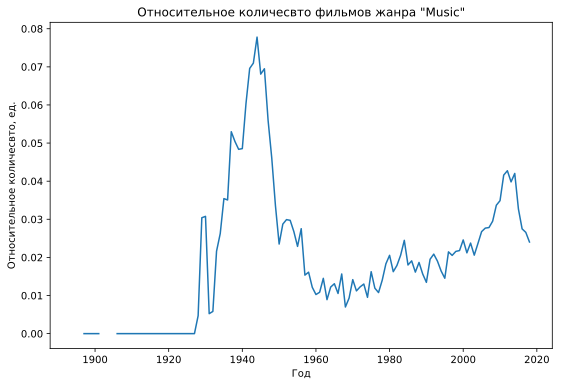

In [12]:
# Посмотрим что получилось на примере музыкальных фильмов

plt.plot(main['year'], main['Music'] / main['number'])

plt.xlabel('Год')
plt.ylabel('Относительное количесвто, ед.')
plt.title('Относительное количесвто фильмов жанра "Music"')

plt.show()


Кино является существенно социальным явлением, очевидно тесно связанными с процессами происходящими в обществе. Несомненно, такие значимые явления как война, экономические кризисы, антропотоки (перемещение больших масс людей), должно оказывать значимое влияние на жанры киноискусства. 


Количественной мерой влияния этих социальных факторов на кино могут служить соответствующие корреляции с изменениями в жанрах киноискусства.

Значимость социального явления можно представить как финитную функцию (имеющую начаоло и конец) на некотором отрезке времени. Для удобства вычисления финитную функцию значимости можно аппроксимировать нормальным распределением. 

In [13]:
from scipy.stats import norm

In [14]:
def historical_event(start_year, length=1, min_year=min_year, max_year=max_year, col_list=col_list, main=main):
   
    sd = length / 2
    mean = start_year + sd
    
    x_axis = np.arange(min_year, max_year, 1)
    
    # Вводим функию нормальным распределением для социального явления
    data = norm.pdf(x_axis,mean,sd)
    data = data / data.max()

    genre_corr = pd.Series()
    
    for i in col_list:
        # Корреляция нестандартизована и является условной
        #genre_cor[i] = np.corrcoef((main[i] / main['number']).fillna(0),data)[0][1]
        genre_corr[i] = np.corrcoef((main[i] / main['number']).fillna(0)/(main[i] / main['number']).max(),data)[0][1]

    top_5 = genre_corr.sort_values(ascending=False).head(5)
    
    #Блок вывода графиков
    # Нормированная функия распределением для социального явления
    plt.plot(x_axis, data, alpha=0.3, linewidth=5)
    
    #Три первых нормированных жанра 
    
    plt.plot(main['year'], (main[top_5.index[0]] / main['number'])/(main[top_5.index[0]] / main['number']).max(), alpha=1, linewidth=2)
    plt.plot(main['year'], (main[top_5.index[1]] / main['number'])/(main[top_5.index[1]] / main['number']).max(), alpha=0.6, linewidth=2)
    plt.plot(main['year'], (main[top_5.index[2]] / main['number'])/(main[top_5.index[2]] / main['number']).max(), alpha=0.4, linewidth=2)
    
    legend_dict=['Historical event',top_5.index[0], top_5.index[1], top_5.index[2]]
    
    plt.xlabel('Год')
    plt.ylabel('Нормированная шкала, ед.')
    plt.title('Относительное количесвто фильмов разного жанра')
    plt.legend(labels=legend_dict, loc='upper left')
    plt.grid()
    plt.xlim(1900,2020)
    plt.ylim(-0.05,1.05)
    plt.show()
    print('Условная корреляция для первых пяти жанров')
    print(top_5)

#### Историческое событие 1

Рассмтрим для начала вторую мировую войну. Зададим это историческое событие (1939-1945)средне 1942 +- 3 

Необходимо учитывать время на производства фильма. Примем его равным 2 годам.

Критерий "влияет-не влияет" можно выбрать, исходя из порогового значения условной корреляции, равного 0.5. Все что ниже 0.5 считается некоррелируемыми событиями.

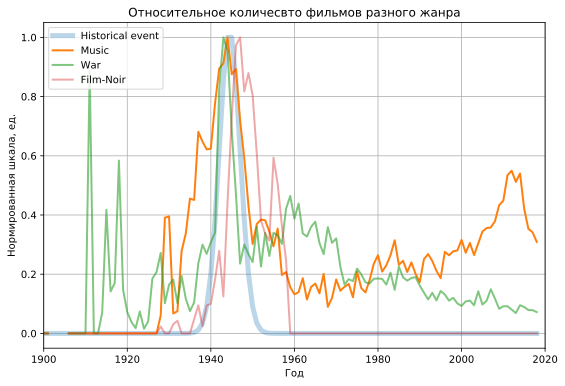

Условная корреляция для первых пяти жанров
Music        0.697219
War          0.634121
Film-Noir    0.625595
Mystery      0.497033
Musical      0.414623
dtype: float64


In [15]:
historical_event(1942,5)

#### Вывод:

Очевидно, что такое эпохальное событие как вторая мировая война оказала сильное влияние на смещение жанров кино в сторону военных и музыкальных фильмов. 

#### Историческое событие 2

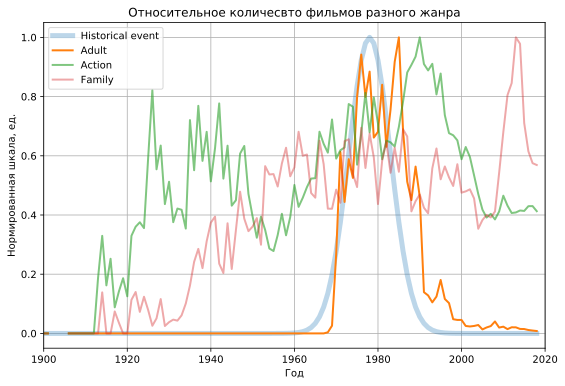

Условная корреляция для первых пяти жанров
Adult     0.889485
Action    0.369643
Family    0.351746
Sci-Fi    0.296077
Horror    0.295604
dtype: float64


In [16]:
historical_event(1973,10)

#### Вывод:

Другим значимым явлением яляется резкий рост фильмов эротического соджержания т.н. жанра Adult, что по времени совпало с сексуальной революцией, которая в свою очередь явилась следствием появления надежных и доступных средств контрацепции. 

#### Историческое событие 3

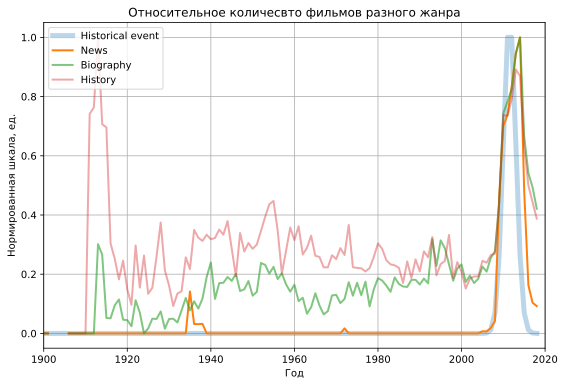

Условная корреляция для первых пяти жанров
News           0.864134
Biography      0.723551
History        0.512856
Documentary    0.505596
Family         0.373442
dtype: float64


In [17]:
historical_event(2010,3)

#### Вывод:

Крупные кризисы мировой экономики(30-е, 2008) также сильно повлияли на смещение жанров кино в сторону новостей - это видно из графика.

#### Заключение
Метод применим только для финитных событий. Явления мирового масштаба (выход человека в космос, появление компьютерых технологий), являющиеся выходом на новый технологический уровень, финитными событиями не являются, и по этому подобный упрощенный анализ к ним неприменим.